# Inferential Analysis of Developer Compensation Across Countries

This project explores the question:  

**Are young software developers (age 18–24) in the US and Germany paid equally, or is there a significant salary gap?**

I use the Stack Overflow 2024 Developer Survey, focusing on rigorous data cleaning, transformation, and statistical analysis to ensure meaningful results.

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from scipy.stats import t
from scipy.stats import ttest_ind
from matplotlib.gridspec import GridSpec

In [111]:
# --- Helper Function ---

def subplot(w, label='', color='', bins=int):
    fig = plt.figure(figsize=(8, 5))
    gs = GridSpec(2, 1, height_ratios=[3, 1])
    ax1 = fig.add_subplot(gs[0])
    sns.histplot(w, bins=bins, ax=ax1, color=f'{color}')
    ax1.set_title(f'{label}')
    ax1.set_xlabel('Salary')
    ax1.set_ylabel('Count')
    ax2 = fig.add_subplot(gs[1])
    sns.boxplot(x=w, ax=ax2, color=f'{color}')
    ax2.set_title(f'{label}')
    ax2.set_xlabel('Salary')
    ax2.set_ylabel('')
    plt.tight_layout()
    plt.show()

## Loading the Data

In [112]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('survey_results_public.csv')
df.shape

(65437, 114)

## Data Preparation: Focusing the Analysis

The survey contains tens of thousands of responses. To make a fair, apples-to-apples comparison, I:
- **Filter** for developers in the US and Germany
- **Limit** to respondents aged 18–24
- **Remove** salaries below country-specific minimum wage standards
- **Drop** incomplete records (e.g., missing work experience)

In [113]:
mask = (
    (df['Country'].isin(['Germany', 'United States of America'])) &
    (df['Age'] == '18-24 years old') &
    (df['ConvertedCompYearly'].notnull())
)
df_young = df[mask].copy()

In [114]:
len(df_young)

714

In [115]:
df_young['Country'].value_counts()

United States of America    424
Germany                     290
Name: Country, dtype: int64

In [116]:
min_wage_germany = 30401 #converted to dollar
min_wage_us = 35568
df_young_filtered = df_young[
    ((df_young['Country'] == 'Germany') & (df_young['ConvertedCompYearly'] >= min_wage_germany)) |
    ((df_young['Country'] == 'United States of America') & (df_young['ConvertedCompYearly'] >= min_wage_us))
]

In [117]:
df_young_filtered['Country'].value_counts()

United States of America    384
Germany                     156
Name: Country, dtype: int64

In [118]:
de = df_young_filtered[df_young_filtered['Country'] == 'Germany']
us = df_young_filtered[df_young_filtered['Country'] == 'United States of America']

In [119]:
print('Germany sample Size :',len(de),' ' 
      'Us sample size:',len(us))


Germany sample Size : 156  Us sample size: 384


In [120]:
us_clean = us.dropna(subset=['WorkExp'])
de_clean = de.dropna(subset=['WorkExp'])

In [121]:
print('Germany-Clean sample Size :',len(de_clean),' ' 
      'Us-Clean sample size:',len(us_clean))

Germany-Clean sample Size : 108  Us-Clean sample size: 241


## Exploratory Data Analysis (EDA)

Before any modeling, I explore the salary distributions for each country:
- Visualize with histograms and boxplots
- Compute skewness

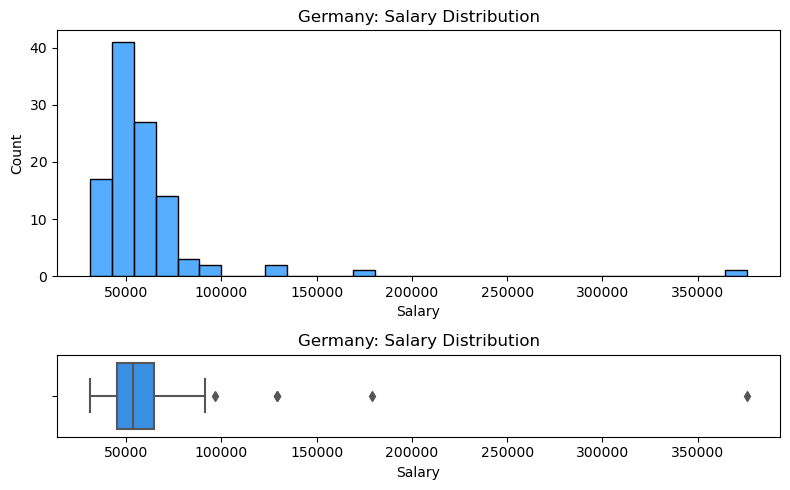

In [122]:
subplot(de_clean['ConvertedCompYearly'], label= 'Germany: Salary Distribution', color= 'dodgerblue', bins= 30)

In [123]:
de_clean.ConvertedCompYearly.skew()

6.452788185346978

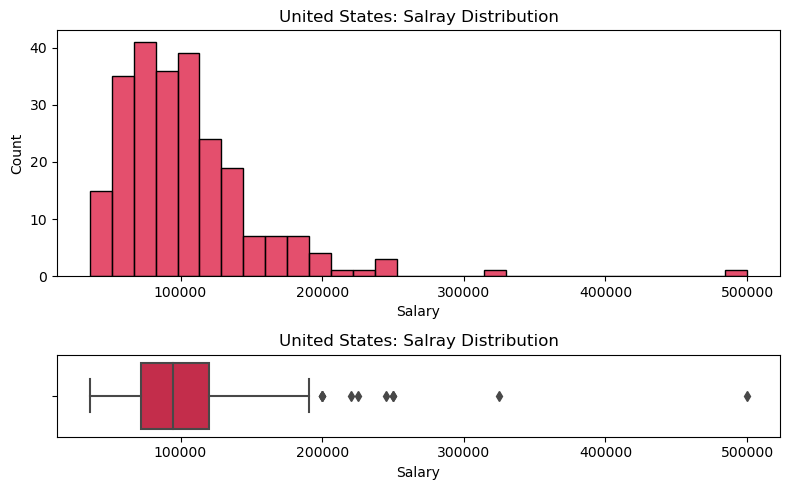

In [124]:
subplot(us_clean['ConvertedCompYearly'], label= 'United States: Salray Distribution', color= 'crimson', bins= 30)

In [125]:
us_clean.ConvertedCompYearly.skew()

2.9396980795170755

## Transformation & Trimming

Raw salary data in both groups showed high right skewness (6.45 and 2.93). To address this, I apply a natural log transformation using `np.log1p()`. Then, I will deal with outliers by applying `pd.quantile()` to remove extrem enteries. The expectation is that both measuers will signfactly reduce skewness

In [126]:
de_clean['LogSalary'] = np.log1p(de_clean['ConvertedCompYearly'])
us_clean['LogSalary'] = np.log1p(us_clean['ConvertedCompYearly'])

/var/folders/tm/f180h_jd4k3678l687xfd8km0000gn/T/ipykernel_6519/1813276312.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  de_clean['LogSalary'] = np.log1p(de_clean['ConvertedCompYearly'])
/var/folders/tm/f180h_jd4k3678l687xfd8km0000gn/T/ipykernel_6519/1813276312.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_clean['LogSalary'] = np.log1p(us_clean['ConvertedCompYearly'])


In [127]:
germany_98 = de_clean['LogSalary'].quantile(0.98)
de_clean_trimmed = de_clean[ de_clean['LogSalary'] < germany_98]

us_99 = us_clean['LogSalary'].quantile(0.995)
us_clean_trimmed = us_clean[ us_clean['LogSalary'] < us_99]

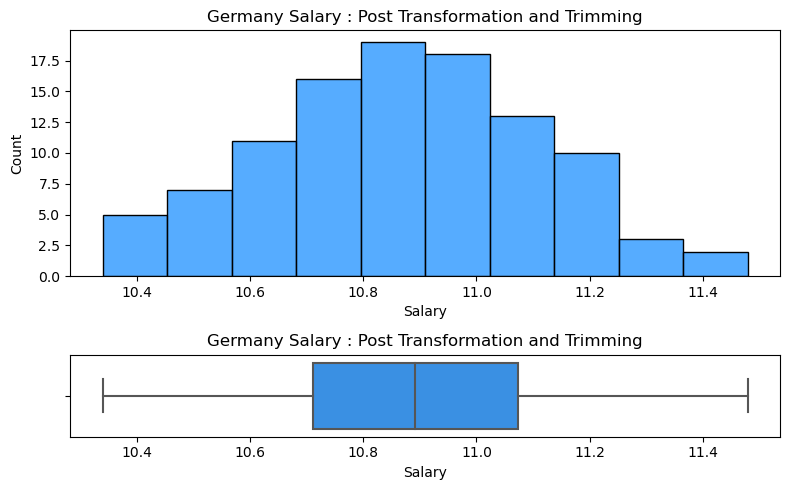

In [128]:
subplot(de_clean_trimmed.LogSalary, label= 'Germany Salary : Post Transformation and Trimming', color= 'dodgerblue', bins= 10)

In [129]:
de_clean_trimmed.LogSalary.skew()

-0.017000280838482103

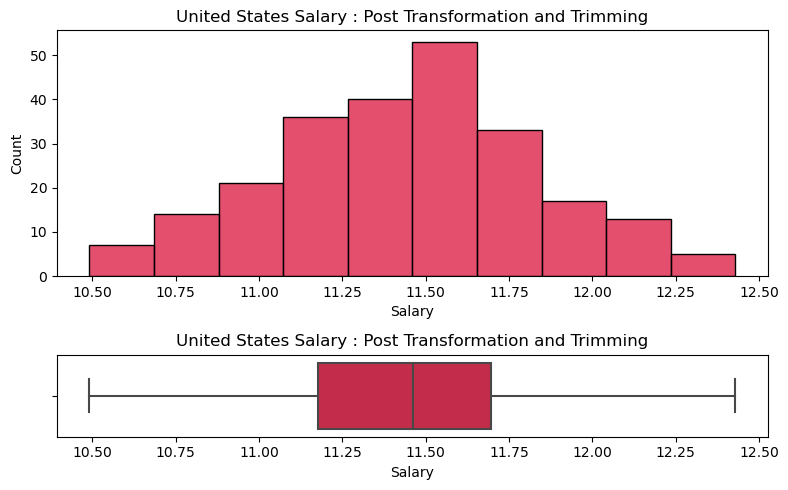

In [130]:
subplot(us_clean_trimmed.LogSalary, label= 'United States Salary : Post Transformation and Trimming', color= 'crimson', bins= 10)

In [131]:
us_clean_trimmed.LogSalary.skew()

0.03636784363494462

## Hypothesis Testing

With clean, transformed data, I formally test:
- **H₀:** US and German young developer salaries are equal (on average)
- **H₁:** There is a difference in average salaries

I use the Welch’s t-test, which is robust to unequal sample sizes and variances.

In [132]:
t_stat, p_val = ttest_ind(us_clean_trimmed.LogSalary, 
                          de_clean_trimmed.LogSalary, 
                          equal_var=False)

print(t_stat, p_val)

16.20288168803127 5.776035654572501e-43


## Calculating the Salary Gap

I compute the 95% confidence interval for the difference in log-mean salaries, then exponentiate to interpret the result as a percent difference in average salary between the US and Germany.

In [134]:
mean_de_log = de_clean_trimmed.LogSalary.mean()
mean_us_log = us_clean_trimmed.LogSalary.mean()

std_de_log = de_clean_trimmed.LogSalary.std(ddof=1)
std_us_log = us_clean_trimmed.LogSalary.std(ddof=1)

diff_m_log = mean_us_log - mean_de_log

print(mean_de_log,
      mean_us_log,
      std_de_log,
      std_us_log,
      diff_m_log)



10.881382600599588 11.442357236062094 0.24058000596683965 0.39175738292515533 0.5609746354625056


In [ ]:
n1, n2 = len(de_clean_trimmed.LogSalary), len(us_clean_trimmed.LogSalary)

se1, se2 = std_de_log / np.sqrt(n1), std_us_log / np.sqrt(n2)

se_diff = np.sqrt(se1**2 + se2**2)

df = (se1**2 + se2**2)**2 / ((se1**4 / (n1-1)) + (se2**4 / (n2-1)))

t_crit = t.ppf(0.975, df )

moe = t_crit * se_diff

ci_lo = diff_m_log - moe 
ci_upp = diff_m_log + moe

print((ci_lo, ci_upp))



(0.4928449541783957, 0.6291043167466155)


In [138]:
print('The 95% Confidence Interval for the percent difference in average salary between the United States and Germany:',(np.expm1(ci_lo) * 100, np.expm1(ci_upp) * 100))


The 95% Confidence Interval for the percent difference in average salary between the United States and Germany: (63.696669686600835, 87.59295878424324)


## Regression Analysis

To see if the US–Germany gap remains after accounting for education and experience, I fit a regression model with:
- Outcome: Log salary
- Predictors: Country, education level, work experience

This lets us isolate the "country effect" net of these other important variables.

In [139]:
# Concatenate the cleaned dataframes
df_reg = pd.concat([de_clean_trimmed, us_clean_trimmed], axis=0)

# Fit the model (treat Country and EdLevel as categorical)
model = smf.ols('LogSalary ~ C(Country) + C(EdLevel) + WorkExp', data=df_reg).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              LogSalary   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     34.64
Date:                Wed, 09 Jul 2025   Prob (F-statistic):           1.16e-39
Time:                        13:52:40   Log-Likelihood:                -98.583
No. Observations:                 343   AIC:                             215.2
Df Residuals:                     334   BIC:                             249.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

## Regression Diagnostics

I check the normality of model residuals using a Q-Q plot. The residuals are nearly perfectly normal, confirming that my assumptions for inference are well satisfied.


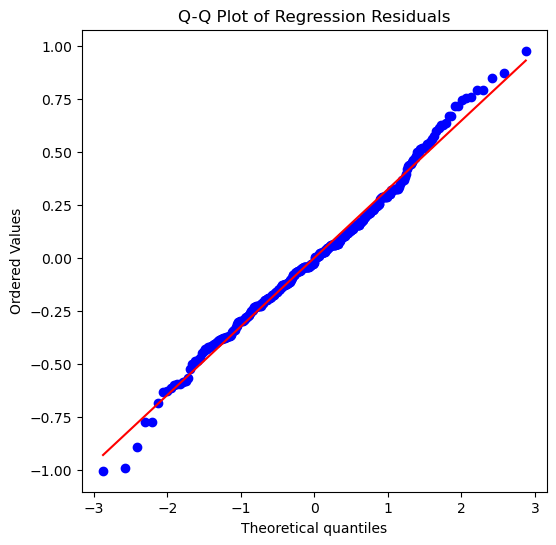

In [140]:
resd = model.resid
plt.figure(figsize=(6,6))
stats.probplot(resd, dist="norm", plot=plt)
plt.title("Q-Q Plot of Regression Residuals")
plt.show()

## Final Results and Interpretation

After rigorous data cleaning, outlier removal, and adjustment for education and work experience, my regression analysis shows:

- **Country effect (US vs. Germany):**

    - **t-statistic:** 13.108
    - **p-value:** p < 0.05
    - **Coefficient (log salary):** 0.5513
    - **95% Confidence Interval**  59.8% to 88.5%

**Conclusion:**  
I am 95% confident that the interval (59.8% to 88.5%) contains the true percentage difference in mean salaries between young (age 18–24) developers in the United States and Germany, after adjusting for education and work experience.